# Predicting Car Prices

In this guided project, we will predict a car's market price using its attributes. The data set we will be working with contains information on various cars. For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. You can read more about the data set [here](https://archive.ics.uci.edu/ml/datasets/automobile) and can download it directly from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data).

Let's start by reading in the dataset.

In [149]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

In [150]:
cars = pd.read_csv('imports-85.data', names = ['symboling', 'normalized_losses','make', 'fuel_type', 'aspiration',
                                              'num_doors', 'body_style', 'drive_wheels', 'engine_location',
                                              'wheel_base', 'length', 'width', 'height', 'curb_weight',
                                              'engine_type', 'num_cylinders', 'engine_size', 'fuel_system',
                                              'bore', 'stroke', 'compression_ratio', 'horsepower',
                                              'peak_rpm', 'city_mpg', 'highway_mpg', 'price'])

In [151]:
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [152]:
cars.shape

(205, 26)

In [153]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized_losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel_type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num_doors          205 non-null    object 
 6   body_style         205 non-null    object 
 7   drive_wheels       205 non-null    object 
 8   engine_location    205 non-null    object 
 9   wheel_base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb_weight        205 non-null    int64  
 14  engine_type        205 non-null    object 
 15  num_cylinders      205 non-null    object 
 16  engine_size        205 non

Since we would like to predict car prices, the target column is `price`. Currently the `price` column is not in numeric format. We need to clean it up. 

## Data cleaning

We usually cannot have any missing values if we want to use them for predictive modeling. Based on the data set preview above, we can tell that the `normalized_losses` column contains missing values represented using `?`. Let's replace these values and look for the presence of missing values in other numeric columns. Let's also rescale the values in the numeric columns so they all range from 0 to 1.

In [154]:
cars = cars.replace('?', np.NaN)

Because `?` is a string value, columns containing this value were cast to the pandas `object` data type (instead of a numeric type like `int` or `float`). Let's determine which columns should be converted back to numeric values and convert them.

In [155]:
numeric_cols = ['normalized_losses', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg', 'price']

cars[numeric_cols] = cars[numeric_cols].astype('float')

Let's see how many rows in the `normalized_losses` column have missing values. 

In [156]:
cars['normalized_losses'].isnull().sum()

41

There are a few ways we could handle columns with missing values:

- Replace the missing values using the average values from that column.
- Drop the rows entirely (especially if other columns in those rows have missing values).
- Drop the column entirely.

When it comes to the `normalized_losses` column, dropping the rows with missing values would result in too much data loss - 20% of the rows.

Let's see how many rows with missing data there are in the rest of the numeric columns.

In [157]:
cars[numeric_cols].isnull().sum()

normalized_losses    41
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_size           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

The `price` column is our target column. Let's drop the four rows with missing values in that column.

In [158]:
cars = cars.dropna(subset=['price'])
cars[numeric_cols].isnull().sum()

normalized_losses    37
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_size           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 0
dtype: int64

Let's fill in the missing values of the remaining columns with the mean value for each column.

In [159]:
for col in numeric_cols:
    cars[col] = cars[col].fillna(cars[col].mean())

In [160]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          201 non-null    int64  
 1   normalized_losses  201 non-null    float64
 2   make               201 non-null    object 
 3   fuel_type          201 non-null    object 
 4   aspiration         201 non-null    object 
 5   num_doors          199 non-null    object 
 6   body_style         201 non-null    object 
 7   drive_wheels       201 non-null    object 
 8   engine_location    201 non-null    object 
 9   wheel_base         201 non-null    float64
 10  length             201 non-null    float64
 11  width              201 non-null    float64
 12  height             201 non-null    float64
 13  curb_weight        201 non-null    float64
 14  engine_type        201 non-null    object 
 15  num_cylinders      201 non-null    object 
 16  engine_size        201 non

Now, let's normalize the numeric columns to range from 0 to 1, excluding the `price` column.

In [161]:
for col in numeric_cols[:-1]:
    cars[col] = (cars[col]-cars[col].min())/(cars[col].max()-cars[col].min())

In [162]:
cars[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
normalized_losses,201.0,0.298429,0.167520,0.0,0.188482,0.298429,0.376963,1.0
wheel_base,201.0,0.355598,0.176862,0.0,0.230321,0.303207,0.460641,1.0
length,201.0,0.494045,0.183913,0.0,0.383582,0.479104,0.632836,1.0
width,201.0,0.477697,0.179613,0.0,0.324786,0.444444,0.538462,1.0
height,201.0,0.497222,0.203985,0.0,0.350000,0.525000,0.641667,1.0
curb_weight,201.0,0.414145,0.200658,0.0,0.264158,0.359193,0.557797,1.0
engine_size,201.0,0.248587,0.156781,0.0,0.139623,0.222642,0.301887,1.0
bore,201.0,0.564793,0.191480,0.0,0.435714,0.550000,0.742857,1.0
stroke,201.0,0.565192,0.150499,0.0,0.495238,0.580952,0.638095,1.0
compression_ratio,201.0,0.197767,0.250310,0.0,0.100000,0.125000,0.150000,1.0


## Univariate Model

Let's start with some univariate k-nearest neighbors models.

In [163]:
def knn_train_test(train_col, target_col, df):
    """Takes in a df, target and training columns, runs a KNearest Neighbor model and returns the RMSE
    Args:
        train_col - the dataframe column on which we will train the model
        target_col - the dataframe column which we would like to predict
        df (pd DataFrame) - the dataframe which we use to train the model
    
    Outputs:
        RMSE - the root mean square error of the model
    """
    knn = KNeighborsRegressor()
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Split the dataset in two (75:25):
    train_set = rand_df[:int(len(rand_df)*0.75)]
    test_set = rand_df[int(len(rand_df)*0.75):]
    
    knn.fit(train_set[[train_col]], train_set[target_col])
    predictions = knn.predict(test_set[[train_col]])
    
    #Calculate the RMSE
    rmse = mean_squared_error(test_set[target_col], predictions, squared=False)
    return rmse

In [164]:
rmses = {}

for col in numeric_cols[:-1]:
    rmses[col] = knn_train_test(col, 'price', cars)

rmses_series = pd.Series(rmses)
rmses_series = rmses_series.sort_values()
rmses_series

engine_size          3051.434222
city_mpg             3684.803554
width                3917.227670
curb_weight          4011.450036
wheel_base           4161.947972
highway_mpg          4323.502530
horsepower           4756.983755
length               5416.294064
compression_ratio    5958.572328
normalized_losses    6231.311124
peak_rpm             6326.471744
bore                 6507.421953
height               6666.667678
stroke               6939.691440
dtype: float64

Now let's modify the `knn_train_test()` function to accept a parameter for the k value.
For each numeric column, we will create, train, and test a univariate model using the following k values (1, 3, 5, 7, and 9). We will then visualize the results using a scatter plot.

In [165]:
def knn_train_test_k(train_col, target_col, df, k_values=5):
    """Takes in a df, target and training columns, runs a KNearest Neighbor model and returns the RMSE
    Args:
        train_col - the dataframe column on which we will train the model
        target_col - the dataframe column which we would like to predict
        df (pd DataFrame) - the dataframe which we use to train the model
        k_value (int, optional) - the value for the n_neighbors, default=5
    
    Outputs:
        k_rmses (dict) - a dictionary with k as key and the RMSE for value  
    """
    
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Split the dataset in two:
    train_set = rand_df[:int(len(rand_df)*0.75)]
    test_set = rand_df[int(len(rand_df)*0.75):]
    
    k_rmses = {}
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(train_set[[train_col]], train_set[target_col])
        predictions = knn.predict(test_set[[train_col]])
    
        #Calculate the RMSE
        rmse = mean_squared_error(test_set[target_col], predictions, squared=False)
        k_rmses[k] = rmse
    return k_rmses

In [166]:
k_rmse_result = {}

for col in numeric_cols[:-1]:
    k_rmse_result[col] = knn_train_test_k(col, 'price', cars, k_values= range(1,10,2))

k_rmse_result

{'normalized_losses': {1: 6499.876425672999,
  3: 6373.107123484384,
  5: 6231.311123986794,
  7: 6434.331952881507,
  9: 6534.518371010953},
 'wheel_base': {1: 2740.62572288541,
  3: 3417.1446705321687,
  5: 4161.947971897813,
  7: 4572.080496976003,
  9: 4488.496411259577},
 'length': {1: 5297.150036557764,
  3: 5507.625440160827,
  5: 5416.294063685402,
  7: 5030.583828449936,
  9: 4407.827047652169},
 'width': {1: 2791.733012966368,
  3: 4083.105499312811,
  5: 3917.2276702270137,
  7: 3722.033525295731,
  9: 3665.167444110463},
 'height': {1: 8302.179086735921,
  3: 7159.369749588925,
  5: 6666.667677627373,
  7: 6570.390279532118,
  9: 6484.278955313533},
 'curb_weight': {1: 3906.6625644092765,
  3: 4156.281651639599,
  5: 4011.4500359082417,
  7: 3811.5247071791855,
  9: 3914.8184777366964},
 'engine_size': {1: 2830.4032415548004,
  3: 2726.617989002506,
  5: 3051.4342223507515,
  7: 3009.8809966252047,
  9: 2951.5863108544913},
 'bore': {1: 8034.701162128302,
  3: 6084.36254271

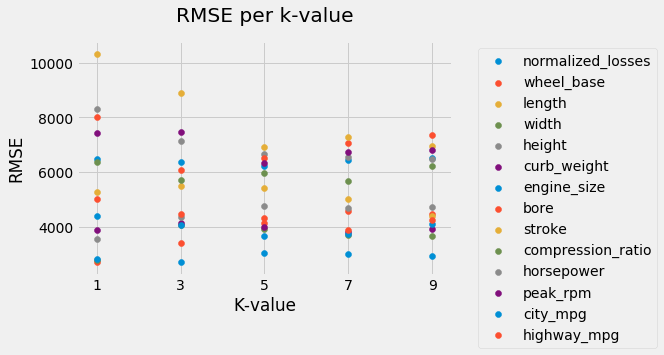

In [167]:
for k, v in k_rmse_result.items():
    x = list(v.keys())
    y = list(v.values())
    plt.scatter(x, y, label=k)
    plt.xlabel('K-value')
    plt.ylabel('RMSE')
    plt.xticks(x)
    plt.title('RMSE per k-value', y=1.06)
    plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

It seems that a **k-value of 5** is optimal for the **Univariate model**.

## Multivariate Model

Now, let's calculate the average RMSE accross different `k` values for each feature. 

Afterwards, we will modify the `knn_test_train()` function to work with multiple columns. 

Then we will use the modified function to calculate the RMSE when using the top 2, 3, 4, and 5 best features.

In [168]:
#Calculate the average RMSE across different `k` values for each feature.

avg_rmse = {}

for k, v in k_rmse_result.items():
    key = k
    value = np.mean(list(v.values()))
    avg_rmse[key] = value
    
avg_rmse_series = pd.Series(avg_rmse)
avg_rmse_series = avg_rmse_series.sort_values()
avg_rmse_series

engine_size          2913.984552
width                3635.853430
wheel_base           3876.059055
curb_weight          3960.147487
city_mpg             4003.950230
highway_mpg          4394.793153
horsepower           4416.336170
length               5131.896083
compression_ratio    5988.485823
normalized_losses    6414.628999
peak_rpm             6955.553334
bore                 7005.432042
height               7036.577150
stroke               8078.044616
dtype: float64

In [169]:
def knn_train_test_list(train_cols, target_col, df):
    """Takes in a df, target and training columns, runs a KNearest Neighbor model and returns the RMSE
    Args:
        train_cols - the dataframe columns on which we will train the model
        target_col - the dataframe column which we would like to predict
        df (pd DataFrame) - the dataframe which we use to train the model
    
    Outputs:
        RMSE - the root mean square error of the model
    """
    knn = KNeighborsRegressor()
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Split the dataset in two:
    train_set = rand_df[:int(len(rand_df)*0.75)]
    test_set = rand_df[int(len(rand_df)*0.75):]
    
    knn.fit(train_set[train_cols], train_set[target_col])
    predictions = knn.predict(test_set[train_cols])
    
    #Calculate the RMSE
    rmse = mean_squared_error(test_set[target_col], predictions, squared=False)
    return rmse

In [170]:
#Now, let's use the 2, 3, 4, and 5 best features from the previous step with default k value of 5.

best_features = {}

for x in range(2,6):
    rmse = knn_train_test_list(avg_rmse_series.index[:x], 'price', cars)
    best_features['RMSE for Features: {}'.format(list(avg_rmse_series.index[:x]))] = rmse

In [171]:
best_features

{"RMSE for Features: ['engine_size', 'width']": 2638.287274194467,
 "RMSE for Features: ['engine_size', 'width', 'wheel_base']": 2634.3882310997487,
 "RMSE for Features: ['engine_size', 'width', 'wheel_base', 'curb_weight']": 2399.3737483588766,
 "RMSE for Features: ['engine_size', 'width', 'wheel_base', 'curb_weight', 'city_mpg']": 2543.664238540805}

It looks like the **Multivariate model** preforms best with **four features**.

## Hyperparameter Tuning

Let's now optimize the model that performed the best in the previous step.

For the top three models from the previous step, we will vary the hyperparameter value from 1 to 25 and plot the resulting values.

In [172]:
def knn_train_test_k(train_col_list, target_col, df):
    """Takes in a df, target and training columns, runs a KNearest Neighbor model with k-values from 1-26 and returns the RMSE
    Args:
        train_col_list (list) - a list of columns on which to train the model
        target_col - the dataframe column which we would like to predict
        df (pd DataFrame) - the dataframe which we use to train the model
    
    Outputs:
        k_rmses (dict) - a dict containing the RMSE for each k-value
    """
    
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Split the dataset in two:
    train_set = rand_df[:int(len(rand_df)*0.75)]
    test_set = rand_df[int(len(rand_df)*0.75):]
    
    k_values = range(1,26)
    k_rmses = {}
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(train_set[train_col_list], train_set[target_col])
        predictions = knn.predict(test_set[train_col_list])
    
        #Calculate the RMSE
        rmse = mean_squared_error(test_set[target_col], predictions, squared=False)
        k_rmses[k] = rmse
    return k_rmses

In [173]:
top3 = [3,4,5]

top3_rmse = {}

for x in top3:
    rmse = knn_train_test_k(avg_rmse_series.index[:x], 'price', cars)
    top3_rmse['Best {} features'.format(x)] = rmse

In [174]:
top3_rmse

{'Best 3 features': {1: 2037.493938400703,
  2: 2420.528728094218,
  3: 2466.335154811804,
  4: 2500.1180896129295,
  5: 2634.3882310997487,
  6: 2638.3042600762296,
  7: 2707.0835451696375,
  8: 2722.4567546507747,
  9: 2818.4424513137938,
  10: 2896.475263346206,
  11: 2848.7049142909195,
  12: 2976.516912023164,
  13: 3018.674738954696,
  14: 3151.1076747917155,
  15: 3308.8805984260784,
  16: 3401.759092567612,
  17: 3505.29174118991,
  18: 3610.00223375181,
  19: 3616.158541761227,
  20: 3680.22666115825,
  21: 3725.1163223927992,
  22: 3787.534502731638,
  23: 3808.838793741088,
  24: 3815.4423107223315,
  25: 3883.5938729773807},
 'Best 4 features': {1: 2054.308886219402,
  2: 2312.1377161898145,
  3: 2342.6297026519737,
  4: 2297.287468833795,
  5: 2399.3737483588766,
  6: 2483.1128692111097,
  7: 2655.597307504255,
  8: 2753.481913222979,
  9: 2869.211518068187,
  10: 2876.2827368589724,
  11: 2790.066817576287,
  12: 2854.342162940999,
  13: 2847.3193772453174,
  14: 2946.704

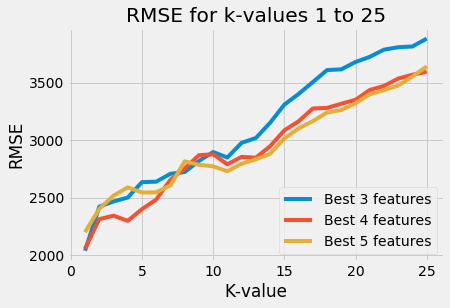

In [175]:
for k, v in top3_rmse.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x, y, label=k)
    plt.legend(loc='lower right')
    plt.xlabel('K-value')
    plt.ylabel('RMSE')
    plt.title('RMSE for k-values 1 to 25')
plt.show()

It seems like using a **k-value 1** is best for the model when using the **best 3, 4 and 5 features**.

## K-fold cross validation

Now, let's modify the `knn_train_test()` function to use k-fold cross validation. We will use the default `n_neighbors` of 5 and will loop through folds 2 to 10.

In [176]:
def knn_train_test_kfold(train_col, target_col, df, folds=range(2,12,2)):
    """Takes in a df, target and training columns, runs a KNearest Neighbor model with a k-fold cross-validation
    Args:
        train_col - the columns on which to train the model
        target_col - the dataframe column which we would like to predict
        df (pd DataFrame) - the dataframe which we use to train the model
        folds (int, optional) - the number of folds to be used for KFold validation
    
    Outputs:
        avg_rmses (dict) - a dict containing the average RMSE for each KFold
    """
    avg_rmses = {}
    
    for f in folds:
        kf = KFold(f, shuffle=True, random_state=1)
        knn = KNeighborsRegressor()
    
        mse = cross_val_score(knn, df[[train_col]], df[target_col], scoring='neg_mean_squared_error', cv=kf)
        rmse = np.sqrt(np.absolute(mse))
        avg_rmse = np.mean(rmse)
        avg_rmses[f] = avg_rmse

    return avg_rmses

In [177]:
diff_folds = {}

for col in numeric_cols[:-1]:
    diff_folds[col] = knn_train_test_kfold(col, 'price', cars, folds=range(2,12,2))
    
diff_folds_df = pd.DataFrame(diff_folds)
diff_folds_df

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
2,7482.632289,5709.567683,5645.803155,4480.755962,7735.811797,4130.915690,3364.285473,6561.161516,7768.258096,6875.609561,3983.289877,7721.986452,4788.022045,4336.427993
4,6910.432610,5601.049008,5217.793716,4305.112854,7723.547222,4331.335448,3287.796580,6475.031311,7407.897334,6455.122963,3802.623017,7564.959829,4157.873935,4402.370669
6,7495.827796,5945.565378,5314.853031,4207.797327,7704.673968,3965.294847,3219.961874,6854.558582,7722.122646,6195.073611,3839.065975,7569.317860,4269.760675,4283.341086
8,6900.152199,5744.523778,5320.497538,4319.527199,7667.115403,4059.026943,3141.847651,6556.757544,7517.688928,6182.827390,3843.473451,7533.791225,4369.852715,4075.701847
10,6671.869661,5725.179143,5344.389417,4209.420018,7702.821601,4234.188078,3043.502927,6914.254048,7297.139641,6082.597131,3801.849871,7510.544452,4305.536968,4180.874800


We see that for 6 out of the 14 columns (~43%), 10 folds give the best result. Because of that, we will use 10 folds for the rest of the tests.

## Varying nearest neighbours

Now let's modify the `knn_train_test_kfold()` so that the k nearest neighbors changes - 1, 3, 5, 7, 9.

In [178]:
def knn_train_test_kfold(train_col, target_col, df, folds=10):
    """Takes in a df, target and training columns, runs a KNearest Neighbor model
    Args:
        train_col - the columns on which to train the model
        target_col - the dataframe column which we would like to predict
        df (pd DataFrame) - the dataframe which we use to train the model
        folds (int, optional) - the number of folds to be used for KFold validation
    
    Outputs:
        avg_rmses (dict) - a dict containing the average RMSE for each k-value
    """
    avg_rmses = {}
    kf = KFold(folds, shuffle=True, random_state=1)
    k_values = range(1,10,2)
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        mse = cross_val_score(knn, df[[train_col]], df[target_col], scoring='neg_mean_squared_error', cv=kf)
        rmse = np.sqrt(np.absolute(mse))
        avg_rmse = np.mean(rmse)
        avg_rmses[k] = avg_rmse
    
    return avg_rmses
    

In [179]:
cols_k = {}

for col in numeric_cols[:-1]:
    cols_k[col] = knn_train_test_kfold(col, 'price', cars, folds=10)
    
cols_k_df=pd.DataFrame(cols_k)

cols_k_df

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
1,7579.057448,4127.664023,4898.478019,4066.868124,8392.337279,5157.859842,3601.796747,8057.920723,8225.659301,6741.420713,3991.682326,8725.320610,5756.990928,5108.460253
3,7148.990331,4791.446221,5055.359831,4014.256862,7867.419571,4495.974906,3054.441896,6514.966390,7273.057903,5821.947865,3860.005144,7721.733869,4388.057423,4648.040609
5,6671.869661,5725.179143,5344.389417,4209.420018,7702.821601,4234.188078,3043.502927,6914.254048,7297.139641,6082.597131,3801.849871,7510.544452,4305.536968,4180.874800
7,7076.278964,5949.354619,5407.596946,4362.409681,7663.933333,4065.269237,3346.551409,6940.746752,7332.833386,6251.986521,3799.826781,7487.471490,4247.140019,4136.835757
9,7376.047238,5847.402960,5461.100326,4316.124588,7491.422748,3961.532240,3496.675613,6752.362175,7299.626100,6330.739278,3843.219943,7564.611083,4414.995561,4168.970779


Now, let's use the above results for `k-values` [1,3,5,9] and average the results for each feature. We will then use the top features to calculate the RMSE for more than one column over 10 folds.

In [180]:
#Calculate the average RMSE across different `k` values for each feature.

avg_rmse_k = {}

for k, v in cols_k.items():
    key = k
    value = np.mean(list(v.values()))
    avg_rmse_k[key] = value
    
avg_rmse_k_series = pd.Series(avg_rmse_k)
avg_rmse_k_series = avg_rmse_k_series.sort_values()
avg_rmse_k_series

engine_size          3308.593718
horsepower           3859.316813
width                4193.815855
curb_weight          4382.964861
highway_mpg          4448.636439
city_mpg             4622.544180
length               5233.384908
wheel_base           5288.209393
compression_ratio    6245.738302
bore                 7036.050018
normalized_losses    7170.448729
stroke               7485.663266
peak_rpm             7801.936301
height               7823.586906
dtype: float64

In [181]:
def knn_train_test_kfold(train_col, target_col, df, folds=10):
    """Takes in a df, target and training columns, runs a KNearest Neighbor model
    Args:
        train_col - the columns on which to train the model
        target_col - the dataframe column which we would like to predict
        df (pd DataFrame) - the dataframe which we use to train the model
        folds (int, optional) - the number of folds to be used for KFold validation
    
    Outputs:
        avg_rmses (dict) - a dict containing the average RMSE for each k-value
    """
    kf = KFold(folds, shuffle=True, random_state=1)
    knn = KNeighborsRegressor()
    
    mse = cross_val_score(knn, df[train_col], df[target_col], scoring='neg_mean_squared_error', cv=kf)
    rmse = np.sqrt(np.absolute(mse))
    avg_rmse = np.mean(rmse)
    return avg_rmse

In [182]:
features = {}

for x in range(2,7):
    result = knn_train_test_kfold(list(avg_rmse_k_series.index[:x]), 'price', cars, folds=10)
    features["{} best features".format(x)] = result
    
features

{'2 best features': 2808.4983984193304,
 '3 best features': 3031.767371260333,
 '4 best features': 3010.436378520319,
 '5 best features': 3031.8000284536897,
 '6 best features': 3097.0129847108556}

It looks like the **10 fold model** and **k value of 5** preforms best with **2 features**.

Let's use the top 3 features combinations from above (2, 3, 4, 5) and calculate the RMSE with varying nearest neighbors from 1 to 25, using 10 folds.

In [183]:
def knn_train_test_kfold(train_col, target_col, df, folds=10):
    """Takes in a df, target and training columns, runs a KNearest Neighbor model
    Args:
        train_col - the columns on which to train the model
        target_col - the dataframe column which we would like to predict
        df (pd DataFrame) - the dataframe which we use to train the model
        folds (int, optional) - the number of folds to be used for KFold validation
    
    Outputs:
        avg_rmses (dict) - a dict containing the average RMSE for each k-value
    """
    kf = KFold(folds, shuffle=True, random_state=1)
    
    avg_rmses = {}
    for k in range(1,26):
        knn = KNeighborsRegressor(n_neighbors=k)
    
        mse = cross_val_score(knn, df[train_col], df[target_col], scoring='neg_mean_squared_error', cv=kf)
        rmse = np.sqrt(np.absolute(mse))
        avg_rmse = np.mean(rmse)
        avg_rmses[k] = avg_rmse
    return avg_rmses

In [184]:
features_25 = {}

features = [2,3,4,5]

for x in features:
    result = knn_train_test_kfold(list(avg_rmse_k_series.index[:x]), 'price', cars, folds=10)
    features_25["{} best features".format(x)] = result
    
features_25

{'2 best features': {1: 2844.6738023575053,
  2: 2601.2320598273477,
  3: 2636.5883949955796,
  4: 2787.516162198912,
  5: 2808.4983984193304,
  6: 2845.3008673634185,
  7: 2934.275309828578,
  8: 3137.167365122338,
  9: 3205.8876254263178,
  10: 3285.3850135510047,
  11: 3422.1375743796843,
  12: 3550.5516722965376,
  13: 3691.4335807073912,
  14: 3793.5952330652267,
  15: 3868.994116314313,
  16: 3897.4576330716213,
  17: 3933.2465918697517,
  18: 4025.3490798025623,
  19: 4085.6682300076645,
  20: 4140.402487825685,
  21: 4166.786411146952,
  22: 4205.597041611041,
  23: 4278.854191048603,
  24: 4336.7415031100345,
  25: 4396.694250351881},
 '3 best features': {1: 2726.9297759497135,
  2: 2703.564030002367,
  3: 2781.5659507487435,
  4: 2919.9368436139735,
  5: 3031.767371260333,
  6: 3163.352228814234,
  7: 3301.7360046271315,
  8: 3334.8298982284878,
  9: 3363.2517083798375,
  10: 3386.824559906182,
  11: 3411.1854293862043,
  12: 3427.6208376397676,
  13: 3509.0328877950074,
  14

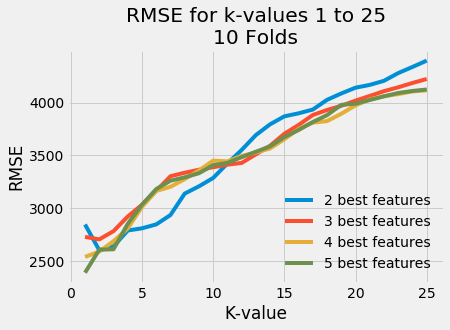

In [185]:
for k, v in features_25.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x, y, label=k)
    plt.legend(loc='lower right', frameon=False)
    plt.xlabel('K-value')
    plt.ylabel('RMSE')
    plt.title('RMSE for k-values 1 to 25\n10 Folds')
plt.show()

It looks like **2, 3, and 4 best features** produce most accurate results with **k value of 2** whereas **5 features** work best with **k value of 1**.

## Conclusion

In this guided project, we used a dataset containing different car attributes to predict the price of each car and calculate the RMSE of the predictions. we experimented with varying values for n_neigbors in the KNearest Neighbor model as well as with different number of folds for the KFold cross validation.